## Find best model

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, Lasso, SGDRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.pipeline import Pipeline

import time

STATE = 42

In [2]:
data = pd.read_csv('../data/fullData.csv', index_col='Код объекта')
data.head()

,"(1933.999, 1948.5]","(1948.5, 1963.0]","(1963.0, 1977.5]","(1977.5, 1992.0]","(1992.0, 2006.5]","(2006.5, 2021.0]",Серия_1-335,Серия_1-335А,Серия_2-68-1-0,Серия_335-с,...,Материал окон_Пластиковые/деревянные,гостевой паркинг,всего этажей,Общая площадь,Высота потолков,Комнатность,подземный паркинг,цена,вид на дороги,вид на культуру
Код объекта,,,,,,,,,,,,,,,,,,,,,
5757236,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,30.60,2.50,1.0,0.0,2390.0,0.0,0.0
5535905,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,5.0,18.00,2.55,1.0,0.0,920.0,0.0,0.0
4644398,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,5.0,57.83,2.70,3.0,0.0,3250.0,0.0,0.0
5667276,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,16.0,41.20,2.70,2.0,0.0,3590.0,0.0,0.0
4644417,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,5.0,84.00,2.70,4.0,0.0,4500.0,0.0,0.0


In [3]:
X = data.drop(columns='цена')
Y = data['цена']

In [4]:
X.columns

Index(['(1933.999, 1948.5]', '(1948.5, 1963.0]', '(1963.0, 1977.5]',
       '(1977.5, 1992.0]', '(1992.0, 2006.5]', '(2006.5, 2021.0]',
       'Серия_1-335', 'Серия_1-335А', 'Серия_2-68-1-0', 'Серия_335-с',
       'Серия_75 ', 'Серия_75.1, 3-75', 'Серия_А-1', 'Серия_Бреж', 'Серия_Инд',
       'Серия_Общ', 'Серия_Хрущ', 'Стены_Блочные', 'Стены_Деревянные',
       'Стены_Кирпичные', 'Стены_Монолитные', 'Стены_Панельные',
       'Адрес_Голиковка', 'Адрес_Древлянка', 'Адрес_Зарека', 'Адрес_Ключевая',
       'Адрес_Кукковка', 'Адрес_Октябрьский', 'Адрес_Первомайский',
       'Адрес_Перевалка', 'Адрес_Сулажгора', 'Адрес_Центр',
       'Балкон_Балкон и лоджия', 'Балкон_Два балкона и более',
       'Балкон_Есть балкон', 'Балкон_Лоджия', 'Ремонт_Косметический ремонт',
       'Ремонт_Ремонт по дизайн проекту', 'Ремонт_Современный ремонт',
       'Ремонт_Требует ремонта', 'Ремонт_Улучшенная черновая отделка',
       'Ремонт_Частичный ремонт', 'Ремонт_Черновая отделка',
       'Счетчик воды_отсутс

# Постройка baseline модели
предсказание средней стоимости квартиры в зависимости от типа квартиры и района.  
Потсроенная модель машинного обучения должна быть лучше, чем эта

### Преобразование данных в подходящий вид
получить dataframe, содержащий предсказанную стоимость в зависимости от типа квартиры и района

In [5]:
dummy_x_series = X.filter(regex='Серия')
dummy_x_adress = X.filter(regex='Адрес')

In [6]:
l = []
for col_series in dummy_x_series.columns:
    for col_adress in dummy_x_adress:
        dummy_data = X.join(Y).groupby([col_series, col_adress], as_index=False)['цена'].mean()
        l.append(dummy_data)

In [7]:
dummy_df = pd.concat(l).fillna(0)
dummy_df.reset_index(drop=True, inplace=True)
dummy_df

,Серия_1-335,Адрес_Голиковка,цена,Адрес_Древлянка,Адрес_Зарека,Адрес_Ключевая,Адрес_Кукковка,Адрес_Октябрьский,Адрес_Первомайский,Адрес_Перевалка,...,Серия_1-335А,Серия_2-68-1-0,Серия_335-с,Серия_75,"Серия_75.1, 3-75",Серия_А-1,Серия_Бреж,Серия_Инд,Серия_Общ,Серия_Хрущ
0,0.0,0.0,3111.027613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,2756.338462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,2871.428571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,2926.498947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,3776.969072,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,0.0,0.0,2934.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
363,0.0,0.0,3000.185687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
364,0.0,0.0,3725.763636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
365,0.0,0.0,2718.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Получение массива предсказаний цен на квартиры

In [8]:
dummy_x = X.filter(regex='Серия|Адрес')
dummy_x_y = dummy_x.join(Y)

In [9]:
y_dummy = []
for idx in dummy_x.index:
    flat = dummy_x.loc[idx]
    is_dummy_contains_exact_given_flat = (dummy_df[dummy_x.columns] == flat).all(axis=1)
    pred_idx = is_dummy_contains_exact_given_flat[is_dummy_contains_exact_given_flat == True].index
    dummy_prediction = dummy_df.loc[pred_idx, 'цена'].values[0]
    y_dummy.append(dummy_prediction)

### вычисление ошибки

In [10]:
dummy_mae = mean_absolute_error(y_dummy, Y)
dummy_mae

809.4366423673126

### граф частичных остатков

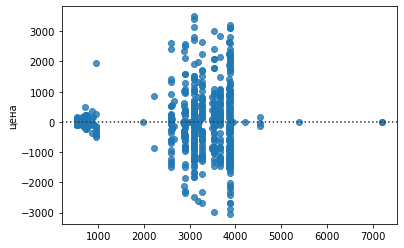

In [11]:
graph = sns.residplot(x=y_dummy, y=Y)


### Распределение ошибки

Text(0.5, 6.79999999999999, 'residuals')

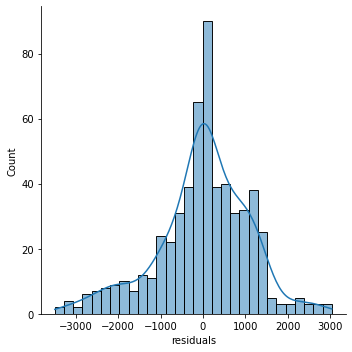

In [12]:
residuals_dummy = y_dummy - Y
sns.displot(residuals_dummy, bins=30, kde=True)
plt.xlabel('residuals')

# Сравнение моделей между собой

In [13]:
metrics = [mean_absolute_error]

In [14]:
models = [DecisionTreeRegressor(random_state=STATE),
          LinearRegression(), 
          Lasso(alpha=0.25, random_state=STATE),
          Ridge(alpha=0.05, random_state=STATE),
          RandomForestRegressor(random_state=STATE),
          SGDRegressor(penalty='l2', random_state=STATE),
          KNeighborsRegressor(50),
          LinearSVR(random_state=STATE)
         ]

In [15]:
def compare_model(models, X, Y, metrics):
    report = {}
    for model in models:
        score = cross_val_score(model, X, Y, cv=5)
        preds = cross_val_predict(model, X, Y, cv=5)
        errors = {}
        errors['score'] = score.mean()
        for metric in metrics:
            error = metric(preds, Y)
            errors[metric.__name__] = error
        m_name = str(model.__class__)
        report[m_name[m_name.rfind('.'):]] = errors
    report = pd.DataFrame.from_dict(report)
    return report.T.sort_values(by='mean_absolute_error')


In [16]:
compare_model(models, X, Y, metrics)

,score,mean_absolute_error
.RandomForestRegressor'>,8.239187e-01,4.229873e+02
.Lasso'>,7.557205e-01,4.543098e+02
.Ridge'>,7.547076e-01,4.574396e+02
.LinearRegression'>,7.540719e-01,4.581549e+02
.KNeighborsRegressor'>,7.497773e-01,5.226210e+02
.DecisionTreeRegressor'>,7.005428e-01,5.380426e+02
.LinearSVR'>,6.015783e-01,5.561825e+02
.SGDRegressor'>,-8.720517e+16,3.049762e+11


# Выбираем признаки и сравниваем ещё раз

In [17]:
from sklearn.feature_selection import SelectFromModel, mutual_info_regression
from sklearn.linear_model import Lasso
selector = SelectFromModel(estimator=Lasso(random_state=STATE, alpha=7)).fit(X, Y)

In [18]:
selected_features = selector.get_support()
selected_columns = X.columns[selected_features]
print(selected_columns)

Index(['(1948.5, 1963.0]', '(1963.0, 1977.5]', '(1992.0, 2006.5]',
       '(2006.5, 2021.0]', 'Серия_Общ', 'Стены_Деревянные', 'Стены_Кирпичные',
       'Стены_Монолитные', 'Адрес_Древлянка', 'Адрес_Зарека', 'Адрес_Ключевая',
       'Адрес_Кукковка', 'Адрес_Октябрьский', 'Адрес_Перевалка',
       'Адрес_Сулажгора', 'Адрес_Центр', 'Балкон_Есть балкон',
       'Ремонт_Косметический ремонт', 'Ремонт_Ремонт по дизайн проекту',
       'Ремонт_Современный ремонт', 'Ремонт_Улучшенная черновая отделка',
       'Ремонт_Частичный ремонт', 'Счетчик воды_отсутствует',
       'Двор_открытый двор', 'Материал окон_Пластиковые', 'гостевой паркинг',
       'всего этажей', 'Общая площадь', 'Высота потолков', 'Комнатность'],
      dtype='object')


In [19]:
compare_model(models, X[selected_columns], Y, metrics)

,score,mean_absolute_error
.RandomForestRegressor'>,8.160965e-01,4.283339e+02
.Lasso'>,7.722047e-01,4.398936e+02
.Ridge'>,7.725196e-01,4.403281e+02
.LinearRegression'>,7.723807e-01,4.404249e+02
.DecisionTreeRegressor'>,7.278284e-01,5.139338e+02
.KNeighborsRegressor'>,7.501816e-01,5.231258e+02
.LinearSVR'>,5.931036e-01,5.628309e+02
.SGDRegressor'>,-1.245964e+17,3.210373e+11


Less columns, and some algorithms show big or smaller error. RFR show best result even some other algorithms got slighly better.

## mutual info regression

In [20]:
mir = mutual_info_regression(X,Y,random_state=STATE)

In [21]:
mir

array([0.00907552, 0.01262269, 0.00708717, 0.05132962, 0.00853851,
       0.07118212, 0.00922904, 0.        , 0.        , 0.01945463,
       0.02290894, 0.        , 0.        , 0.01646442, 0.12824753,
       0.2921939 , 0.0086128 , 0.        , 0.10912704, 0.03568581,
       0.02570725, 0.03704354, 0.01112434, 0.05075795, 0.03900096,
       0.        , 0.01858412, 0.02553815, 0.00268742, 0.        ,
       0.04254443, 0.01883399, 0.        , 0.00302127, 0.04327331,
       0.        , 0.02330039, 0.00618287, 0.03627011, 0.0192994 ,
       0.03440939, 0.02024971, 0.        , 0.01164495, 0.04209384,
       0.        , 0.        , 0.        , 0.16835377, 0.8827404 ,
       0.0277573 , 0.38801173, 0.01187933, 0.0095831 , 0.0287954 ])

zero values do not say anything about Y

In [22]:
bad_idx = np.where(mir <= 0.005)
cols_zero_variance = X.columns[bad_idx]
compare_model(models, X.drop(columns=cols_zero_variance), Y, metrics)

,score,mean_absolute_error
.RandomForestRegressor'>,8.228814e-01,4.236895e+02
.Lasso'>,7.489660e-01,4.513490e+02
.Ridge'>,7.464708e-01,4.548107e+02
.LinearRegression'>,7.452173e-01,4.556170e+02
.KNeighborsRegressor'>,7.500681e-01,5.222954e+02
.DecisionTreeRegressor'>,6.919181e-01,5.435308e+02
.LinearSVR'>,6.001231e-01,5.561909e+02
.SGDRegressor'>,-4.613790e+17,5.264658e+11


# Вывод:
Не убираю столбы, использую модель randomForestRegressor

## Model tuning

In [23]:
import joblib

N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

Number of physical cores: 4


In [24]:
rfr = RandomForestRegressor(random_state=STATE, n_jobs=N_CORES, criterion='absolute_error')

In [25]:
params = {
    'n_estimators': [177, 150, 200, 300, 500],
    'max_depth': [None, 29, 35, 50, 10],
    'min_samples_split': [3, 5, 10, 2],
    'min_samples_leaf': [1, 5, 10,20],
    'max_leaf_nodes': [None, 85, 100, 25],
    'random_state' : [STATE],
    'max_features' : ['sqrt', 1.0, 0.8,0.9]
}

In [26]:
clf = RandomizedSearchCV(rfr, params, random_state=STATE, n_iter=400)

In [27]:
t1 = time.time()
clf.fit(X,Y)
t2 = time.time()
print('time for tuning: ', t2-t1)

time for tuning:  1017.7392246723175


# Before tuning

In [28]:
model = rfr

In [29]:
score = cross_val_score(model, X, Y, cv=5)
score.mean()

0.8217197393567564

In [30]:
preds = cross_val_predict(model, X, Y, cv=5)

In [31]:
mae = mean_absolute_error(preds, Y)
print('mae= ', mae)

mae=  421.1991191709845


# After tuning

In [32]:
clf.best_params_

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_leaf_nodes': None,
 'max_features': 'sqrt',
 'max_depth': None}

базовые параметры самые лучшие...

In [33]:
model = RandomForestRegressor(**clf.best_params_)

In [34]:
score = cross_val_score(model, X, Y, cv=5)
score.mean()

0.8424285969941321

In [35]:
preds = cross_val_predict(model, X, Y, cv=5)

In [36]:
mae = mean_absolute_error(preds, Y)
print('mae= ', mae)

mae=  425.5311892082682


ошибка увеличилась, оставляем базовые параметры  
##### Но проверю влияние числа деревьев на ошибку...

In [37]:
rfr_more_trees = RandomForestRegressor(random_state=STATE, n_jobs=N_CORES, criterion='absolute_error', n_estimators=500)


In [38]:
score = cross_val_score(rfr_more_trees, X, Y, cv=5)
score.mean()

0.8225466093790372

In [39]:
preds = cross_val_predict(rfr_more_trees, X, Y, cv=5)
mae = mean_absolute_error(preds, Y)
print('mae= ', mae)

mae=  421.36511744386877


##### ...и уменьшение

In [40]:
rfr_less_trees = RandomForestRegressor(random_state=STATE, n_jobs=N_CORES, criterion='absolute_error', n_estimators=100)
score = cross_val_score(rfr_more_trees, X, Y, cv=5)
print('mean_score= ', score.mean())
preds = cross_val_predict(rfr_more_trees, X, Y, cv=5)
mae = mean_absolute_error(preds, Y)
print('mae= ', mae)

mean_score=  0.8225466093790372
mae=  421.36511744386877


# Вывод:
оставляю базовые параметры модели

# Финальная оценка работы модели

In [41]:
final_model = RandomForestRegressor(random_state=STATE, n_jobs=N_CORES, criterion='absolute_error')

In [42]:
preds = cross_val_predict(final_model, X, Y, cv=5)

# График частичных остатков

In [43]:
residuals = preds - Y

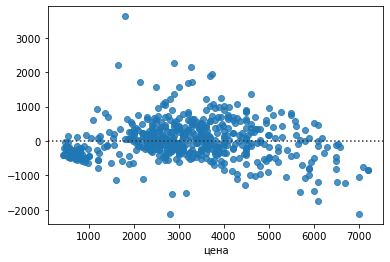

In [44]:
graph = sns.residplot(x=Y, y=preds)

по сравнению с предыдущим графиком, здесь наблюдается меньшая дисперсия в данных

### распределение ошибки

Text(0.5, 6.79999999999999, 'residuals')

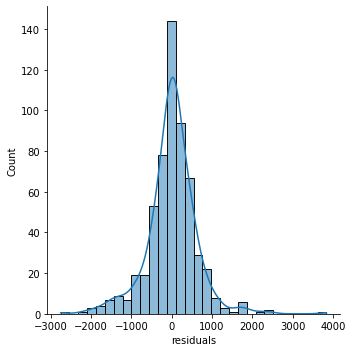

In [45]:
sns.displot(residuals, bins=30, kde=True)
plt.xlabel('residuals')

среднее в нуле, график имеет нормальную форму, закономерности в ошибке не обнаружено

# Сравнение стоимости жилья, истинных цен и предсказанных

In [46]:
Y.iloc[:25].values

array([2390.,  920., 3250., 3590., 4500., 2550., 3000.,  800., 4700.,
       2970., 4000., 2450.,  570., 4200., 1190., 2700., 1999., 3200.,
       5500.,  649., 4000., 2350.,  590.,  700.,  990.])

In [47]:
preds[:25]

array([2498.28,  645.98, 3802.76, 3299.12, 5116.53, 3604.12, 3348.  ,
        857.42, 5121.14, 3366.69, 4005.67, 2507.71,  628.67, 4238.32,
       2416.63, 2304.98, 1525.6 , 3959.54, 5851.44,  615.6 , 3502.29,
       2473.23,  661.66,  777.49, 1093.  ])

Text(0.5, 1.0, 'mae comparation(lower is better)')

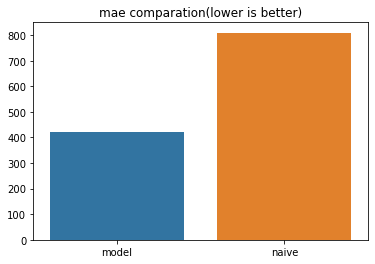

In [48]:
sns.barplot(x=['model', 'naive'], y=[mae, dummy_mae])
plt.title('mae comparation(lower is better)')

### результаты модели лучше, чем у наивного подхода

## Save model

In [49]:
import pickle

In [53]:
final_model.fit(X, Y)

RandomForestRegressor(criterion='absolute_error', n_jobs=4, random_state=42)

In [54]:
with open("model.pkl", "wb") as f:
    pickle.dump(final_model, f)

# Выводы для улучшения результата
Для дальнейшего улучшения результата необходимо больше данных. Всё-таки, менее 600 квартир - это довольно мало